In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
import torch.nn as nn
from torch.autograd import Variable

from netrex.netrex import FactorizationModel, SequenceModel, generate_sequences
from netrex.evaluation import auc_score, mrr_score

from netrex.utils import _cpu, _gpu, _minibatch  # deal with it
from netrex.netrex2 import ShitNet
import itertools
from functools import reduce
from operator import add, mul

from typing import List, Dict

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

embedding_dim = 10
minibatch_size = 2048
n_iter = 10
cuda = False

PATH_INTERACTIONS = '../data/snap_amazon/video_games/ratings_unary.msg'
PATH_USER_FEATS = '../data/snap_amazon/video_games/user_feats.msg'
PATH_ITEM_FEATS = '../data/snap_amazon/video_games/item_feats.msg'

user_col = 'user_id'
item_col = 'asin'
ts_col = 'timestamp'

context_cols = ['month', 'dayofweek']

SEED = 322

split_date = '2014-01-01'

# Load and some more Preproc

In [2]:
xns_df = pd.read_msgpack(PATH_INTERACTIONS).sample(100000, random_state=SEED)
user_feats_df = pd.read_msgpack(PATH_USER_FEATS)
item_feats_df = pd.read_msgpack(PATH_ITEM_FEATS)

In [3]:
# Dummy context features
xns_df['month'] = xns_df['timestamp'].dt.month
xns_df['dayofweek'] = xns_df['timestamp'].dt.dayofweek

In [4]:
# Train-Val split
# in reality, user_feats_df and item_feats_df should have new categories removed too
train_df = xns_df.loc[xns_df[ts_col] < split_date].copy()
val_df = xns_df.loc[xns_df[ts_col] >= split_date].copy()
print(train_df.shape)
print(val_df.shape)

(81513, 5)
(18487, 5)


In [5]:
# Categorical dtype
for col in [user_col, item_col] + context_cols:
    train_df[col] = train_df[col].astype('category')
    val_df[col] = val_df[col].astype('category', categories=train_df[col].cat.categories)
    
cat_d = {
    col: pd.CategoricalIndex(train_df[col].cat.categories, name=col)
    for col in [user_col, item_col] + context_cols
}

In [6]:
(val_df[user_col].notnull() & val_df[item_col].notnull()).value_counts()

False    17826
True       661
dtype: int64

In [7]:
# Add User and Item Feats to catalog
for col in user_feats_df.columns:
    cat_d[col] = pd.CategoricalIndex(user_feats_df[col].cat.categories, name=col)
for col in item_feats_df.columns:
    cat_d[col] = pd.CategoricalIndex(item_feats_df[col].cat.categories, name=col)

# Book-keeping methods

In [8]:
def lookup(feature_fields_ids: Dict[str, Variable],
           feature_maps: Dict[str, nn.Embedding],
           col_dep: str) -> Dict[str, Variable]:
    """
    Lookup values with prerequisites in `feature_fields_ids`
    These results will eventually find their way in `feature_fields_ids`
    """
    return {
        feat_name: feat_map(feature_fields_ids[col_dep]).long().squeeze()
        for feat_name, feat_map in feature_maps.items()
    }
        
    
def lookups_via_features(feats_df: pd.DataFrame, index_cats) -> Dict[str, nn.Embedding]:
    """
    feats_df: user or item features
        index should be user or item id such that the ordering matches user or item codes
        each column should be of dtype category
    # n_indices: number of users or number of items
    index_cats: user or item index catgories (cat_d[user_col].categories) 
    feature_maps: to be used to convert a user or item id into the corresponding feature code
    """
    n_indices = len(index_cats)
    feature_maps = {}
    for col in feats_df.columns:
        emb = nn.Embedding(n_indices, embedding_dim=1, sparse=False)
        emb.weight = nn.Parameter(torch.from_numpy(
            feats_df.loc[index_cats][col].cat.codes.values[:, None].astype('float32')))
        emb.weight.requires_grad = False
        feature_maps[col] = emb
    return feature_maps


user_feature_maps = lookups_via_features(user_feats_df, cat_d[user_col])
item_feature_maps = lookups_via_features(item_feats_df, cat_d[item_col])

def get_fields_ids(user_ids: Variable,
                   item_ids: Variable,
                   contexts: Variable) -> Dict[str, Variable]:
    feature_fields_ids = {
        user_col: user_ids,
        item_col: item_ids,
    }
    feature_fields_ids.update(lookup(feature_fields_ids, user_feature_maps, user_col))
    feature_fields_ids.update(lookup(feature_fields_ids, item_feature_maps, item_col))
    feature_fields_ids.update({col: contexts[:, ii] for ii, col in enumerate(context_cols)})
    # Potentially more complex feature dependency graphs
    
    return feature_fields_ids

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from netrex.layers import ScaledEmbedding, ZeroEmbedding
from netrex.utils import _cpu, _gpu, _minibatch  # deal with it
from typing import Dict, List, Tuple
import pandas as pd
import itertools
from functools import reduce
from operator import add, mul
from time import time
CatsDict = Dict[str, pd.CategoricalIndex]

class FNet(nn.Module):
    
    def __init__(self, cats_d: CatsDict, embedding_dim: int, sparse=False):
        super().__init__()

        self.embedding_dim = embedding_dim

        # TODO: I think the book-keeping can be done within
        # just using named modules
        self.embeddings_d = {
            field: ScaledEmbedding(len(cat_index.categories), embedding_dim,
                                   sparse=sparse)
            for field, cat_index in cats_d.items()
        }
        self.biases_d = {
            field: ZeroEmbedding(len(cat_index.categories), 1,
                                 sparse=sparse)
            for field, cat_index in cats_d.items()
        }

        for field, module in self.embeddings_d.items():
            self.add_module('embedding_{}'.format(field), module)
        for field, module in self.biases_d.items():
            self.add_module('bias_{}'.format(field), module)

    def forward(self, user_ids, item_ids, contexts):

        feature_fields_ids = get_fields_ids(user_ids, item_ids, contexts)

        # Iter of batch_size X embedding_dim tensors
        embeddings = [self.embeddings_d[fields](ids)
                      for fields, ids in feature_fields_ids.items()]
        biases = [self.biases_d[fields](ids)
                  for fields, ids in feature_fields_ids.items()]

        contrib_dot = reduce(add, (
            mul(*pair).sum(1)
            for pair in itertools.combinations(embeddings, 2))
                             )
        contrib_bias = reduce(add, biases)

        return contrib_dot + contrib_bias

In [10]:
class FModel(object):

    def __init__(self,
                 col_cat_index_d,
                 loss='bpr',
                 embedding_dim=64,
                 n_iter=1,
                 batch_size=1024,
                 l2=0.0,
                 use_cuda=False,
                 sparse=False):

        self.col_cat_index_d = col_cat_index_d
        
        self._loss = loss
        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._batch_size = batch_size
        self._l2 = l2
        self._use_cuda = use_cuda
        self._sparse = sparse

        self._num_users = None
        self._num_items = None
#         self._net = None
        self._net = _gpu(
            FNet(self.col_cat_index_d, self._embedding_dim),
            self._use_cuda
        )


    def fit(self, interactions_df, verbose=False):
        self._num_users, self._num_items = (len(interactions_df[col].cat.categories)
                                            for col in [user_col, item_col])
        
        interactions = sp.csr_matrix(
            (np.ones(len(interactions_df)),
             (interactions_df[user_col].cat.codes,
              interactions_df[item_col].cat.codes)),
            shape=(self._num_users, self._num_items), dtype=np.float32)
        
        

        if self._sparse:
            optimizer = optim.Adagrad(self._net.parameters(),
                                      weight_decay=self._l2)
        else:
            optimizer = optim.Adam(self._net.parameters(),
                                   weight_decay=self._l2)

#         loss_fnc = self._bpr_loss
        
        for epoch_num in range(self._n_iter):
            # todo: shuffle in a more efficient way?
            interactions_df = interactions_df.sample(frac=1)
            # Storing in tensors
            user_ids_tensor = _gpu(torch.from_numpy(interactions_df[user_col].cat.codes.values.astype('int64')),
                                   cuda)
            item_ids_tensor = _gpu(torch.from_numpy(interactions_df[item_col].cat.codes.values.astype('int64')),
                                   cuda)
            context_codes_df = pd.concat([interactions_df[col].cat.codes for col in context_cols], axis=1)
            context_codes_df.columns = context_cols

            context_tensor = _gpu(torch.from_numpy(context_codes_df.values.astype('int64')),
                                  cuda)

            epoch_loss = 0.0
            ii = 0
            tic = time()
            for (batch_user, batch_item, batch_context) in zip(
                _minibatch(user_ids_tensor, self._batch_size),
                _minibatch(item_ids_tensor, self._batch_size),
                _minibatch(context_tensor, self._batch_size)):

                user_var = Variable(batch_user)
                pos_item_var = Variable(batch_item)
                context_var = Variable(batch_context)

                pos_score = self._net(user_var, pos_item_var, context_var)
                
                # TODO: there is some repeat work in `neg_feature_fields_ids`
                # that was already done in `pos_feature_fields_ids`
                neg_item_var = Variable(_gpu(
                    torch.from_numpy(np.random.randint(0,
                                                       self._num_items,
                                                       len(pos_item_var))),
                    self._use_cuda))
                neg_score = self._net(user_var, neg_item_var, context_var)

                optimizer.zero_grad()

                loss = (1.0 - F.sigmoid(pos_score -neg_score)).mean()
                epoch_loss += loss.data[0]

                loss.backward()
                optimizer.step()
                
                ii += 1
                if verbose and (ii%50)==0:
                    print('{}: {} \t {}'.format(ii, time()-tic, loss.mean().data[0]))

            if verbose:
                print('Epoch {}: loss {}'.format(epoch_num, epoch_loss))


In [11]:
model = FModel(cat_d, embedding_dim=10, batch_size=256)

In [12]:
val_in_train_df = val_df.loc[val_df[user_col].notnull() & val_df[item_col].notnull()]

In [13]:
# Fit 1 epoch
model.fit(train_df)

In [14]:
# How can we eval?
# eval will be slow because we cannot groupby user
# since we are considering context... oh well
# Let's use a ghetto mean avg precision

def score_model(model, val_in_train_df, k=100):

    user_ids_tensor = _gpu(torch.from_numpy(val_in_train_df[user_col].cat.codes.values.astype('int64')),
                           cuda)
    item_ids_tensor = _gpu(torch.from_numpy(val_in_train_df[item_col].cat.codes.values.astype('int64')),
                           cuda)
    context_codes_df = pd.concat([val_in_train_df[col].cat.codes for col in context_cols], axis=1)
    context_codes_df.columns = context_cols

    context_tensor = _gpu(torch.from_numpy(context_codes_df.values.astype('int64')),
                          cuda)

    items_all = Variable(
        _gpu(torch.arange(0, model._num_items).long(),
             model._use_cuda)
    )

    correct_in_k = []

    for (batch_user, batch_item, batch_context) in zip(
        _minibatch(user_ids_tensor, 1),
        _minibatch(item_ids_tensor, 1),  # Doesn't really need to be tensorized
        _minibatch(context_tensor, 1)):


        user_rep = Variable(batch_user.repeat(model._num_items))
        context_rep = Variable(batch_context.repeat(model._num_items, 1))
        preds = model._net(
            user_rep,
            items_all,
            context_rep
        )

        correct_in_k.append(batch_item.numpy() in np.argpartition(-preds.data.numpy(), kth=k, axis=0)[:k])
        gmap = np.mean(correct_in_k)
    return gmap

In [15]:
%%time
model = FModel(cat_d, embedding_dim=10, batch_size=1024)
scores = []
for ep in range(30):
    model.fit(train_df)
    score = score_model(model, val_in_train_df, k=10)
    print(ep, score)
    scores.append(score)

0 0.0166414523449
1 0.0302571860817
2 0.0438729198185
3 0.0453857791225
4 0.0453857791225
5 0.0438729198185
6 0.0438729198185
7 0.0438729198185
8 0.0453857791225
9 0.0468986384266
10 0.0453857791225
11 0.0468986384266
12 0.0453857791225
13 0.0453857791225
14 0.0468986384266
15 0.0453857791225
16 0.0453857791225
17 0.0468986384266
18 0.0453857791225
19 0.0438729198185
20 0.0453857791225
21 0.0468986384266
22 0.0468986384266
23 0.0423600605144
24 0.0438729198185
25 0.0423600605144
26 0.0423600605144
27 0.0423600605144
28 0.0423600605144
29 0.0423600605144
CPU times: user 3min 55s, sys: 21.2 s, total: 4min 17s
Wall time: 2min 37s


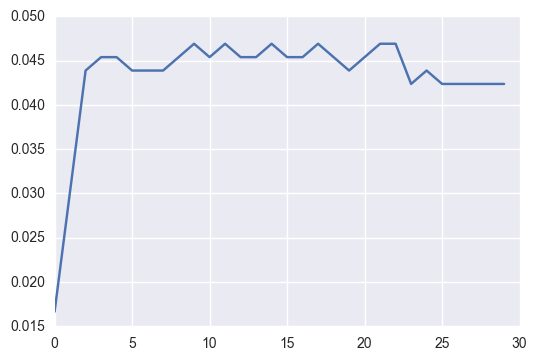

In [16]:
plt.plot(scores)